## Cheatsheet

In [371]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import scikitplot
import datetime
import seaborn as sns
import datetime
import random
import uuid
sns.set()

## Dataset

In [354]:
def get_data():
    df = pd.read_csv('fakedata.csv', index_col='id')
    df['id'] = df.index
    df = df.rename(columns={'class':'label'})
    return df

df = get_data()
df.head()

,amount,country,device,label,name,time,user,id
id,,,,,,,,
4908,105.588116,us,A,0,D U,1.524069e+09,706,4908
6327,103.051363,cn,C,0,H M,1.523752e+09,229,6327
8452,96.187956,ca,D,0,T R,1.523704e+09,393,8452
831,95.236296,us,D,0,L L,1.523919e+09,583,831
7944,94.366095,us,C,0,M S,1.523931e+09,262,7944


In [370]:
categorical = ['country', 'device']
identifiers = ['id', 'user', 'name']
numerical = ['amount']
target = 'label'

## Summary Stats

In [357]:
df.info()
df.describe()
df.nunique()
df.isnull().sum() # null count
df.label.value_counts()
df.describe(include='O') # Categorical columns

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11000 entries, 4908 to 7111
Data columns (total 8 columns):
amount     11000 non-null float64
country    11000 non-null object
device     11000 non-null object
label      11000 non-null int64
name       11000 non-null object
time       11000 non-null float64
user       11000 non-null int64
id         11000 non-null int64
dtypes: float64(2), int64(3), object(3)
memory usage: 773.4+ KB


0    9990
1    1010
Name: label, dtype: int64

## Time


### Time Features (Hour, Min, Day)

In [ ]:
df['datetime'] = df.time.apply(datetime.datetime.fromtimestamp)
df['time_hour'] = df.datetime.dt.round('H')
df['time_day'] = df.datetime.dt.round('D')
df['hour'] = df.datetime.dt.hour
df['minute'] = df.datetime.dt.minute
df['daywk'] = df.datetime.dt.dayofweek
df.head()

## Plotting

### Time Series

In [ ]:
grouped = df.groupby('time_day')
rates = grouped[target].sum() / grouped[target].count()
rates.plot(kind='line');

### Categorical (Bar)

In [ ]:
for c in categorical:
    grouped = df.groupby(c)
    rates = grouped[target].sum() / grouped[target].count()
    print(rates)
    rates.plot(kind='bar')
    plt.show()

### Categorical (Count)

In [ ]:
for c in categorical:
    print(df[c].value_counts())
    sns.countplot(data=df, x=c, hue=target)
    plt.title(c)
    plt.show()

### Histograms (Overlap)

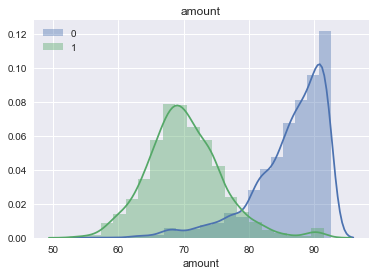

In [382]:
q = df.amount.quantile(q=.3)  # First grab quartiles
for c in numerical:
    sns.distplot(df[(df[target] == 0) & (df.amount < q)][c], bins=20, label='0')
    sns.distplot(df[(df[target] == 1) & (df.amount < q)][c], bins=20, label='1')
    plt.legend()
    plt.title(c)

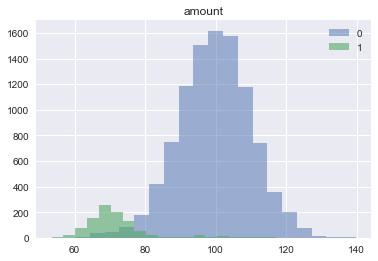

In [383]:
fig = plt.figure()
ax = fig.subplots(nrows=1, ncols=1)
df[df.label == 0].hist(column='amount', bins=20, ax=ax, label='0', alpha=.5)
df[df.label == 1].hist(column='amount', bins=20, ax=ax, label='1', alpha=.6)
plt.legend();

### Histograms (Side-by-side)

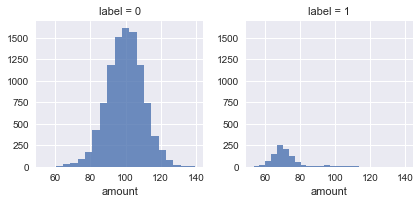

In [379]:
g = sns.FacetGrid(df, col='label')
g.map(plt.hist, 'amount', bins=20, alpha=.8);

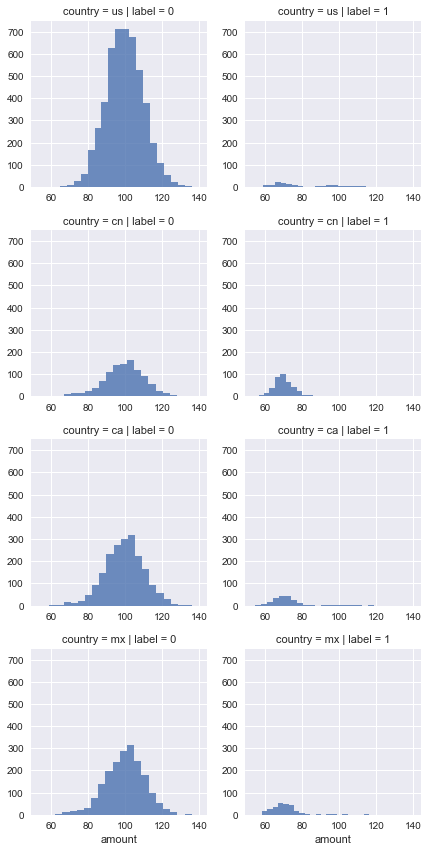

In [380]:
# Facetgrid with value combos + categories
grid = sns.FacetGrid(df, col='label', row='country')
grid.map(plt.hist, 'amount', bins=20, alpha=.8)
grid.add_legend();

## Covariance

### Correlation Matrix and Heatmap

In [ ]:
# Numerical and Time only
corr = df.corr()
fig = plt.figure(figsize=(14,14))
sns.heatmap(corr, annot=True);

### Most Correlated Features

In [ ]:
corr.nlargest(n=5, columns='class')['class']
corr.nsmallest(n=5, columns='class')['class']

## Aggregation

### Basic

In [ ]:
# Multiple statistics
df[['amount', 'daywk']].describe().T

In [ ]:
# Count occurances
df['country'].value_counts()

In [ ]:
# Mode
df[['device', 'country']].mode().T

### Custom Aggregations

In [ ]:
aggregations = {
    'class': {
        'pos': 'sum',
        'total': 'count',
        'rate': lambda x: x.sum() / x.count()
    },
    'amount': {
        'avg_amt': 'mean',
        'med_amt': 'median',
        'std_amt': 'std',
        'mode_smt': lambda x: x.value_counts().index[0]
    },
    'country': {
        'primary_country': lambda x: x.value_counts().index[0],
        'n_countries': lambda x: x.nunique()
    },
    'device': {
        'primary_device': lambda x: x.value_counts().index[0],
        'n_devices': lambda x: x.nunique()
    },
    'datetime': {
        'account_created': 'min',
        'account_age': lambda x: (datetime.datetime.utcnow() - min(x)).days
    }
}

In [ ]:
users = df.groupby('user', as_index=False).agg(aggregations)
users.columns = users.columns.droplevel()
users = users.rename(columns={'':'user'})
users.head()

### Assign columns with custom function

In [ ]:
gb = df.groupby('user').min()['datetime']
def getvalue(x):
    return gb[x]

df['created'] = df['user'].map(getvalue)
df.head()

### Assign Column with Transform

In [ ]:
df['created'] = df.groupby('user')['datetime'].transform(np.min)
df.head()

## Group by

### Single column

In [344]:
# What's the positive rate by country?
df[['country', 'class']].groupby(
    ['country'], as_index=False).mean().sort_values(
    by='class', ascending=False)

,country,class
1,cn,0.277433
2,mx,0.123707
0,ca,0.087868
3,us,0.026740


### Multiple Columns

In [397]:
df.groupby(['country', 'label']).median()

amount          time   user      id
country label                                         
ca      0       99.903656  1.524049e+09  479.0  4821.0
        1       70.663892  1.524027e+09    5.0   525.0
cn      0      100.101118  1.524019e+09  454.0  5132.0
        1       69.816100  1.524028e+09    5.0   496.0
mx      0      100.577683  1.524063e+09  482.0  4940.5
        1       70.031208  1.524007e+09    5.0   530.0
us      0       99.757466  1.524048e+09  504.0  4984.5
        1       72.990321  1.524032e+09    6.0   683.5

### Loop through groups

In [ ]:
group = df[:15].groupby('daywk')
for name, data in group:
    print(data[categorical])
    print('name', name, "primary_ctry", data.country.mode())

### Get Min/Max/Sum for Group

In [ ]:
# Multiple columns
group = df.groupby('daywk')
group.aggregate(np.min).T

In [ ]:
# Single Column
group.created.describe()

## Drop/Rename Columns

In [ ]:
# Rename
df.rename(columns={'class': 'class1'}, inplace=True)
df.rename(columns={'class1': 'class'}, inplace=True)

# Drop
df.drop(labels=['time'], axis=1, inplace=True)
df.head()

## Null Handling

### Drop Null

In [388]:
# Specific column
df = get_data()
df = df.dropna(how='any', subset=['country'])

In [389]:
# Any column
df = df.dropna(how='any')

### Default Values

In [404]:
# Constant
df['label'].fillna(value=-1, inplace=True)

# Median
df['label'].fillna(value=df['label'].median(), inplace=True)

# Multiple
df = df.fillna({
    "label": -1,
    "country": "unkown",
})

### Conditional Values

In [406]:
df['amount'] = np.where((df['amount'] > 2000) & (df['amount'] < 10), 1000, df['amount'])

### Bfill / Ffill

In [405]:
df['label'].fillna(method='bfill', inplace=True)
df['label'].fillna(method='ffill', inplace=True)

## Encoding

### One-Hot Encoding

In [386]:
# Used when order doesn't matter
df = get_data()
df = pd.get_dummies(df, columns=['country'], prefix=['ctr'])
df.head()

,amount,device,label,name,time,user,id,ctr_ca,ctr_cn,ctr_mx,ctr_us
id,,,,,,,,,,,
4908,105.588116,A,0,D U,1.524069e+09,706,4908,0,0,0,1
6327,103.051363,C,0,H M,1.523752e+09,229,6327,0,1,0,0
8452,96.187956,D,0,T R,1.523704e+09,393,8452,1,0,0,0
831,95.236296,D,0,L L,1.523919e+09,583,831,0,0,0,1
7944,94.366095,C,0,M S,1.523931e+09,262,7944,0,0,0,1


### Ordinal Encoding

In [416]:
# Used when order matters (ordinal)
df['country'] = df['country'].astype('category')
df['country'] = df['country'].cat.codes
df.head()

,amount,country,device,label,name,time,user,id,amount_band,new
id,,,,,,,,,,
4908,105.588116,3,A,0,D U,1.524069e+09,706,4908,3,1
6327,103.051363,1,C,0,H M,1.523752e+09,229,6327,2,1
8452,96.187956,0,D,0,T R,1.523704e+09,393,8452,2,1
831,95.236296,3,D,0,L L,1.523919e+09,583,831,2,1
7944,94.366095,3,C,0,M S,1.523931e+09,262,7944,2,1


### Binning

In [413]:
# Used to group continuous values into intervals
df = get_data()
df['amount_band'] = pd.cut(df['amount'], 5, labels=[0,1,2,3,4])
df.head()

,amount,country,device,label,name,time,user,id,amount_band
id,,,,,,,,,
4908,105.588116,us,A,0,D U,1.524069e+09,706,4908,3
6327,103.051363,cn,C,0,H M,1.523752e+09,229,6327,2
8452,96.187956,ca,D,0,T R,1.523704e+09,393,8452,2
831,95.236296,us,D,0,L L,1.523919e+09,583,831,2
7944,94.366095,us,C,0,M S,1.523931e+09,262,7944,2


## Normalization

### Calculate subgroup statistics

In [ ]:
# Standardization by subgroup statistics
group = df.groupby('daywk')
zscore = lambda x: (x - x.mean()) / x.std()
group.transform(zscore).head()

### Standardization

In [ ]:
# Subtract mean and divide by standard deviation
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

### Normalization (Min/Max)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

### Binarization

In [ ]:
# Binarization (continuous --> 0/1)
from sklearn.preprocessing import Binarizer
binarizer = Binarizer(threshold=0.0).fit(X)
X = binarizer.transform(X)

## Feature Engineering

### Conditional Features

In [418]:
df = get_data()

# np.where
df['new'] = np.where(df['amount'] > 10, 1, 0)

# df.loc
df.loc[ df['amount'] > 10, 'amount'] = 1

df.head()

,amount,country,device,label,name,time,user,id,new
id,,,,,,,,,
4908,1.0,us,A,0,D U,1.524069e+09,706,4908,1
6327,1.0,cn,C,0,H M,1.523752e+09,229,6327,1
8452,1.0,ca,D,0,T R,1.523704e+09,393,8452,1
831,1.0,us,D,0,L L,1.523919e+09,583,831,1
7944,1.0,us,C,0,M S,1.523931e+09,262,7944,1


### Map Features

In [430]:
df['yo'] = df[target].map({
    0:'false', 
    1:'true'
})
df.head()

,amount,country,device,label,name,time,user,id,new,yo
id,,,,,,,,,,
4908,1.0,us,A,0,D U,1.524069e+09,706,4908,1,false
6327,1.0,cn,C,0,H M,1.523752e+09,229,6327,1,false
8452,1.0,ca,D,0,T R,1.523704e+09,393,8452,1,false
831,1.0,us,D,0,L L,1.523919e+09,583,831,1,false
7944,1.0,us,C,0,M S,1.523931e+09,262,7944,1,false


## Train/Test Split

### Sample

In [419]:
# Shuffle and sample 50%
features = df.sample(frac=.5)
df.head()

,amount,country,device,label,name,time,user,id,new
id,,,,,,,,,
4908,1.0,us,A,0,D U,1.524069e+09,706,4908,1
6327,1.0,cn,C,0,H M,1.523752e+09,229,6327,1
8452,1.0,ca,D,0,T R,1.523704e+09,393,8452,1
831,1.0,us,D,0,L L,1.523919e+09,583,831,1
7944,1.0,us,C,0,M S,1.523931e+09,262,7944,1


### Convert to Numpy

In [428]:
y = df[target].values
X = df.drop(axis=1, labels=['id', target])   #drop id and clas label
X = X.as_matrix()

### Simple Train/Test Split

In [427]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, shuffle=True # optional shuffle
)

### KFold Split

### Time Series Split

## Modeling

## Metrics